<a href="https://colab.research.google.com/github/Shufen-Yin/Artificial-Intelligence/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Task 1 Data Collection
# Load historical stocks information (company metadata)
stocks = pd.read_csv('historical_stocks.csv')

# Load daily stock prices
prices = pd.read_csv('historical_stock_prices.csv')


In [7]:
# Check the stock metadata
print(stocks.head())
print(stocks.info())

# Check the stock prices
print(prices.head())
print(prices.info())


  ticker exchange                                    name             sector  \
0    PIH   NASDAQ  1347 PROPERTY INSURANCE HOLDINGS, INC.            FINANCE   
1  PIHPP   NASDAQ  1347 PROPERTY INSURANCE HOLDINGS, INC.            FINANCE   
2   TURN   NASDAQ                180 DEGREE CAPITAL CORP.            FINANCE   
3   FLWS   NASDAQ                 1-800 FLOWERS.COM, INC.  CONSUMER SERVICES   
4   FCCY   NASDAQ           1ST CONSTITUTION BANCORP (NJ)            FINANCE   

                     industry  
0  PROPERTY-CASUALTY INSURERS  
1  PROPERTY-CASUALTY INSURERS  
2  FINANCE/INVESTORS SERVICES  
3      OTHER SPECIALTY STORES  
4        SAVINGS INSTITUTIONS  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6460 entries, 0 to 6459
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ticker    6460 non-null   object
 1   exchange  6460 non-null   object
 2   name      6460 non-null   object
 3   sector    5020 non-null   

The stock metadata dataset contains 6460 stocks with information such as ticker, exchange, company name, sector and industry. Note that sector and industry are available for 5020 stocks, so some records have missing industry information.
The stock prices dataset contains 52828 daily price records, including open, close, adjusted close, low, high, volume and date for each ticker. There are a few missing values in price and volume, which need to be handled before further analysis.

In [8]:
# Task 2 Data cleaning
# Identify missing value,

stocks.isnull().sum()
prices.isnull().sum()


,0
ticker,0
open,0
close,0
adj_close,0
low,0
high,0
volume,0
date,1


In [ ]:
# Handle missing valure with foward fill.
prices.ffill(inplace=True)
stocks.ffill(inplace=True)

#prices.bfill(inplace=True)
#stocks.bfill(inplace=True)
#prices.fillna(prices_df.mean(numeric_only=True), inplace=True)



We used forward fill (ffill) to handle missing values in the time series.
For stock prices, it is more reasonable to carry forward the last observed value rather than filling with a global mean, because prices evolve over time and the most recent value is usually a better estimate than the overall average.

Why not using mean:Using the mean would ignore the time dependency and could introduce unrealistic jumps in the price series.

In [9]:
# Check for duplicate entries and remove them
prices.drop_duplicates(inplace=True)
stocks.drop_duplicates(inplace=True)

In [10]:
# Convert the ’Date’ column to a datetime format and set it as the index of your DataFrame.
# Make sure the 'date' column is in datetime format
# errors='coerce' will turn any invalid date strings into NaT (Not a Time)

prices['date'] = pd.to_datetime(prices['date'])
#Set 'date' as the index of the DataFrame
prices.set_index('date', inplace=True)

We converted the date column from string to datetime using pd.to_datetime in strict mode (without coercion), ensuring that all date values remain valid and unchanged in meaning.

We converted the date column to datetime type and set it as the DataFrame index.
This allows us to treat the dataset as a time series, making it easier to filter by date ranges, perform resampling (e.g., monthly or yearly aggregates), and visualize stock prices over time.

In [11]:
# Task 3 Data Segmentation by Decade
# Create a new column 'decade' based on the year in the datetime index
prices['decade'] = (prices.index.year // 10) * 10

# Quick check
print(prices[['ticker', 'close', 'decade']].head())


           ticker  close  decade
date                            
2013-05-08    AHH  11.58  2010.0
2013-05-09    AHH  11.55  2010.0
2013-05-10    AHH  11.60  2010.0
2013-05-13    AHH  11.65  2010.0
2013-05-14    AHH  11.53  2010.0


We created a new decade feature based on the year extracted from the datetime index. Specifically, we computed decade = (year // 10) * 10, so that all years from 2010 to 2019 are labeled as 2010, all years from 2000 to 2009 are labeled as 2000, and so on. This allows us to easily group and compare stock performance across different decades.

In [12]:
# Segment the data into separate DataFrames for each decade
decades = {dec: df for dec, df in prices.groupby('decade')}

# See what decades we have
print("Available decades:", list(decades.keys()))

# Example: look at 1970s data
print(decades[1970].head())

# Example: 2000s
print(decades[2000].head())


Available decades: [1970.0, 1980.0, 1990.0, 2000.0, 2010.0]
           ticker      open     close  adj_close       low      high  volume  \
date                                                                           
1973-05-03    GTY  0.355317  0.355317   0.073339  0.355317  0.430121   16600   
1973-05-11    GTY  0.355317  0.355317   0.073339  0.355317  0.430121     700   
1973-05-18    GTY  0.355317  0.336616   0.069479  0.336616  0.383369     700   
1973-05-21    GTY  0.336616  0.317915   0.065619  0.317915  0.383369    3700   
1973-05-24    GTY  0.243112  0.224411   0.046319  0.224411  0.243112   76700   

            decade  
date                
1973-05-03  1970.0  
1973-05-11  1970.0  
1973-05-18  1970.0  
1973-05-21  1970.0  
1973-05-24  1970.0  
           ticker       open      close  adj_close        low       high  \
date                                                                       
2006-10-12    PEZ  25.250000  25.420000  23.544323  25.200001  25.440001   
2006

We segmented the dataset into separate DataFrames for each decade using groupby('decade').
Each decade’s DataFrame is stored in a dictionary decades with the decade as the key, allowing easy access to, for example, the 1970s data with decades[1970] and the 2000s data with decades[2000].

In [ ]:
# Task 4 Exploratory Data Analysis by Decade

# Merge stock prices with stock information on 'ticker'
# This adds sector information into the prices DataFrame
prices_merged = prices.reset_index().merge(
    stocks[['ticker', 'sector']],
    on='ticker',
    how='left'
)
print(prices_merged.head())

        date ticker   open  close  adj_close    low   high   volume  decade  \
0 2013-05-08    AHH  11.50  11.58   8.493155  11.25  11.68  4633900    2010   
1 2013-05-09    AHH  11.66  11.55   8.471151  11.50  11.66   275800    2010   
2 2013-05-10    AHH  11.55  11.60   8.507822  11.50  11.60   277100    2010   
3 2013-05-13    AHH  11.63  11.65   8.544494  11.55  11.65   147400    2010   
4 2013-05-14    AHH  11.60  11.53   8.456484  11.50  11.60   184100    2010   

    sector  
0  FINANCE  
1  FINANCE  
2  FINANCE  
3  FINANCE  
4  FINANCE  


We merged the stock prices dataset with the stock metadata on ticker using a left join. This adds the sector column to each row in the prices DataFrame, allowing us to perform exploratory analysis by decade and industry.

In [ ]:
# Set date back as index after merge
prices_merged['date'] = pd.to_datetime(prices_merged['date'])
prices_merged.set_index('date', inplace=True)

print(prices_merged.head())
print(prices_merged.columns)

           ticker   open  close  adj_close    low   high   volume  decade  \
date                                                                        
2013-05-08    AHH  11.50  11.58   8.493155  11.25  11.68  4633900    2010   
2013-05-09    AHH  11.66  11.55   8.471151  11.50  11.66   275800    2010   
2013-05-10    AHH  11.55  11.60   8.507822  11.50  11.60   277100    2010   
2013-05-13    AHH  11.63  11.65   8.544494  11.55  11.65   147400    2010   
2013-05-14    AHH  11.60  11.53   8.456484  11.50  11.60   184100    2010   

             sector  
date                 
2013-05-08  FINANCE  
2013-05-09  FINANCE  
2013-05-10  FINANCE  
2013-05-13  FINANCE  
2013-05-14  FINANCE  
Index(['ticker', 'open', 'close', 'adj_close', 'low', 'high', 'volume',
       'decade', 'sector'],
      dtype='object')


After merging, we reset the index and merged on ticker, which converts the original datetime index into a regular column. To ensure the date column is in datetime format and to restore the time series structure, we reconverted it using pd.to_datetime and set it as the DataFrame index

In [ ]:
# Create decade column
prices_merged['decade'] = (prices_merged.index.year // 10) * 10

# Columns we care about for summary stats
num_cols = ['open', 'high', 'low', 'close', 'volume']

# Group by decade and compute mean, median, std
decade_summary = prices_merged.groupby('decade')[num_cols].agg(['mean', 'median', 'std'])

print(decade_summary)


             open                                high                          \
             mean     median          std        mean     median          std   
decade                                                                          
1970     0.642189   0.619792     0.287365    0.658042   0.630208     0.294714   
1980     9.177563   3.981482    17.367815    9.286933   4.055555    17.527718   
1990    34.844858   9.833333   396.713536   35.920187  10.000000   447.128150   
2000    97.177294  15.070000  5149.435809  103.891714  15.290000  5689.187436   
2010    31.236768  19.790001    47.107840   31.609245  20.040001    47.758984   

              low                               close                          \
             mean     median          std        mean     median          std   
decade                                                                          
1970     0.633538   0.609375     0.284491    0.641670   0.619792     0.287178   
1980     9.091164   3.93750

We created a decade column and grouped the merged dataset by decade. For each decade, we computed summary statistics (mean, median, standard deviation) for key numerical columns: open, high, low, close, and volume. This allows us to analyze trends and volatility across decades.

In [ ]:
decade_dfs = {dec: df for dec, df in prices_merged.groupby('decade')}
print("Available decades:", list(decade_dfs.keys()))


Available decades: [1970, 1980, 1990, 2000, 2010]


/tmp/ipython-input-4224886716.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_close = df['close'].resample('M').mean()


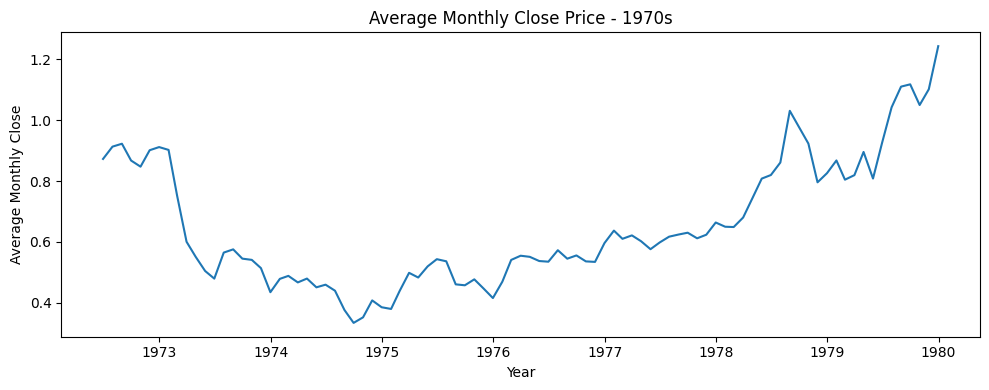

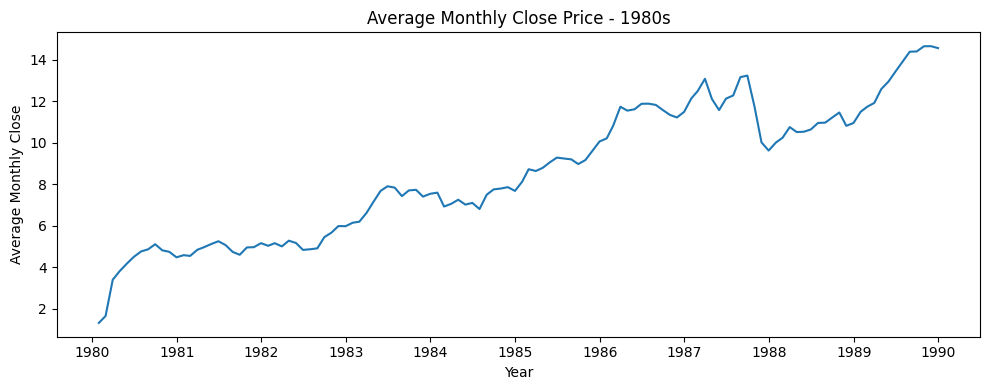

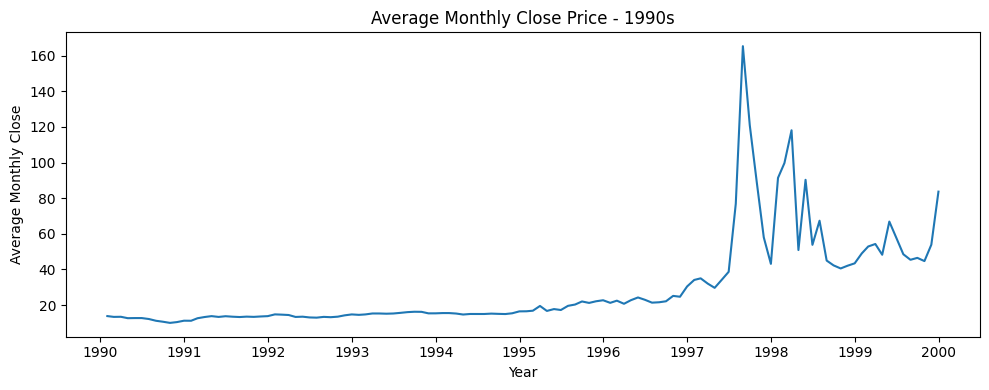

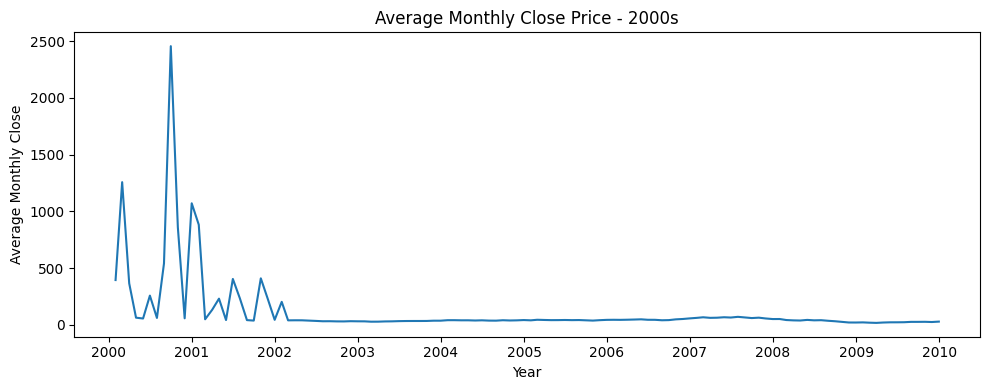

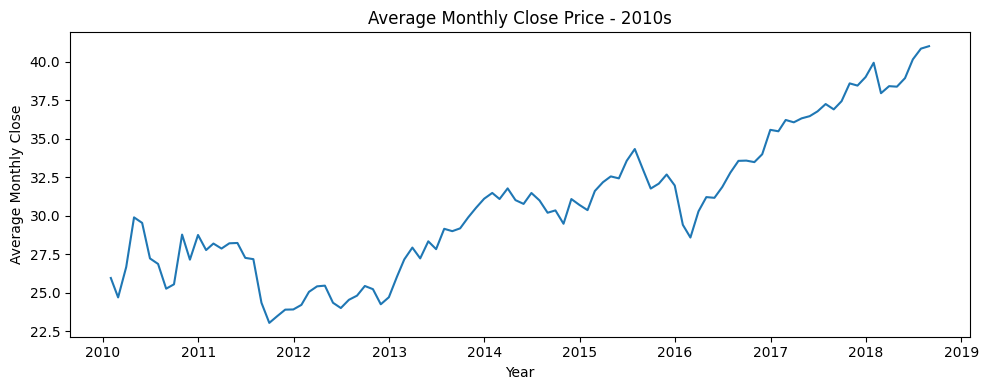

In [ ]:
# Create visualizations for each decade:
# Time series plots: average monthly Close price per decade
for dec, df in decade_dfs.items():
    # Resample to monthly frequency and compute mean Close price
    monthly_close = df['close'].resample('M').mean()

    plt.figure(figsize=(10, 4))
    plt.plot(monthly_close.index, monthly_close.values)
    plt.title(f'Average Monthly Close Price - {dec}s')
    plt.xlabel('Year')
    plt.ylabel('Average Monthly Close')
    plt.tight_layout()
    plt.show()


For each decade, we resampled the daily closing prices to monthly frequency and plotted the average monthly Close to observe long-term trends.

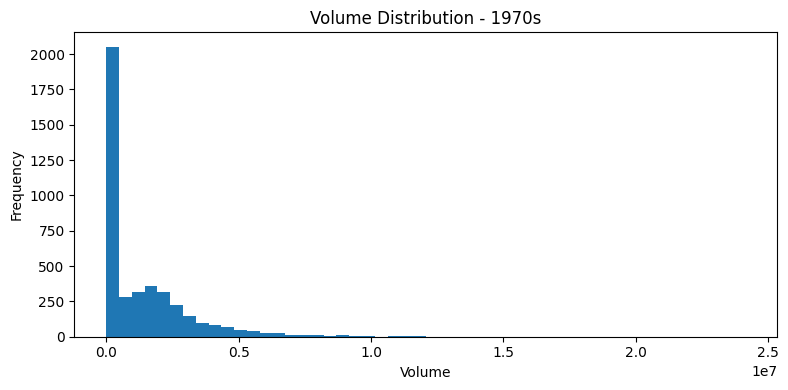

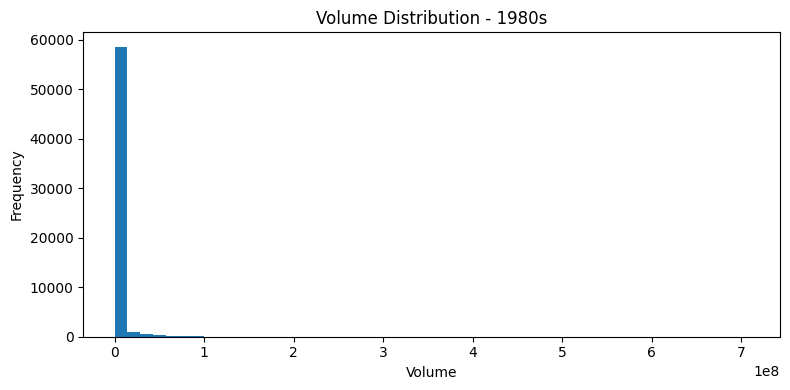

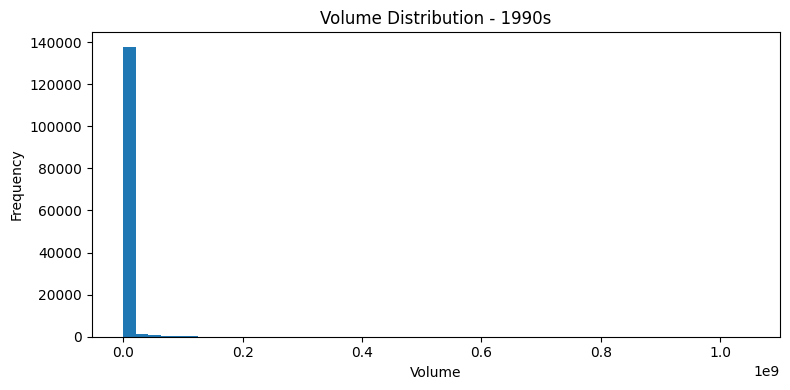

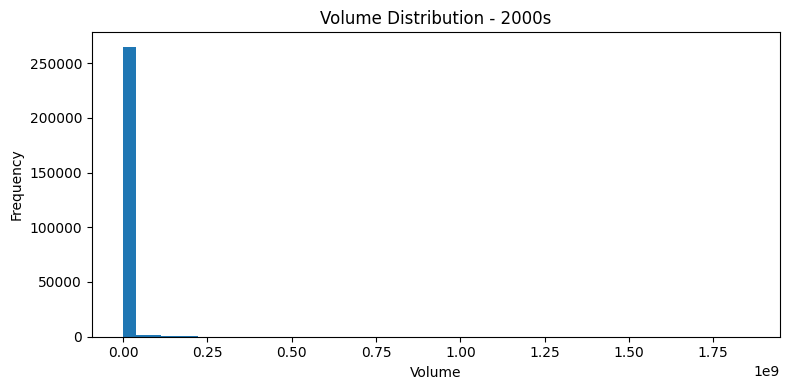

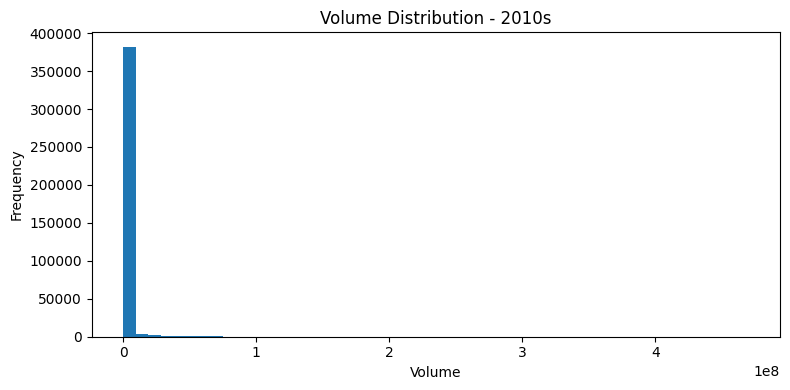

In [ ]:
# Histograms of Volume for each decade
for dec, df in decade_dfs.items():
    plt.figure(figsize=(8, 4))
    plt.hist(df['volume'].dropna(), bins=50)
    plt.title(f'Volume Distribution - {dec}s')
    plt.xlabel('Volume')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()


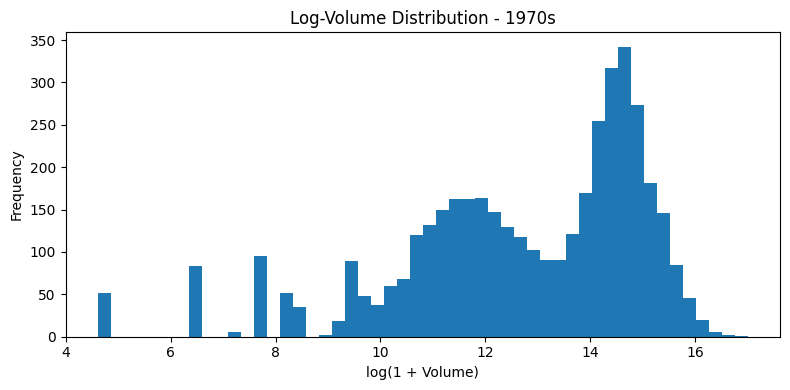

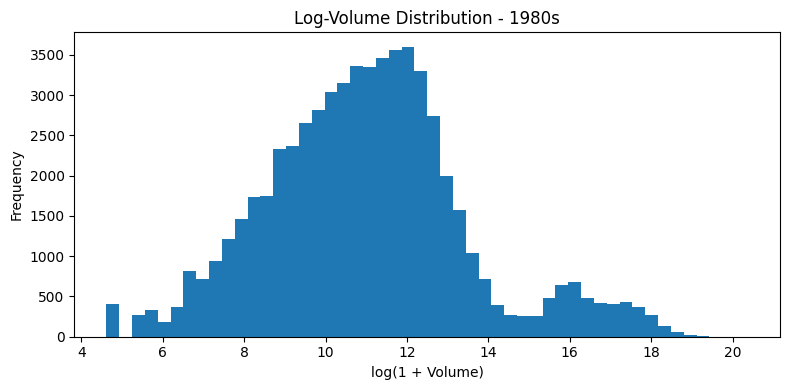

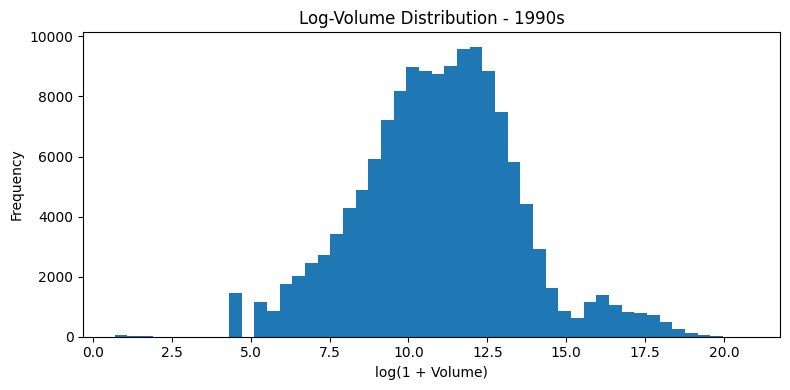

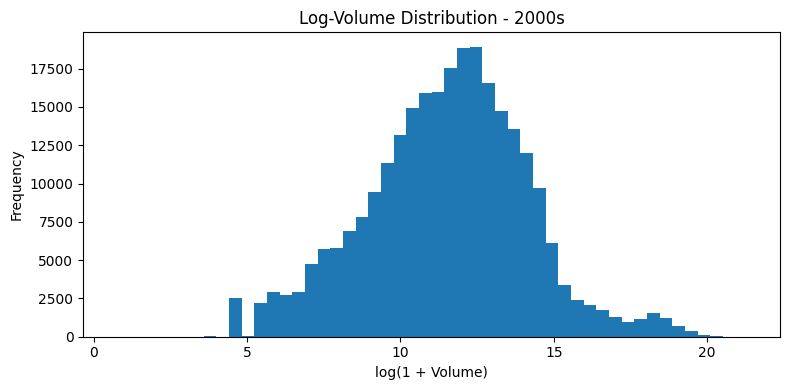

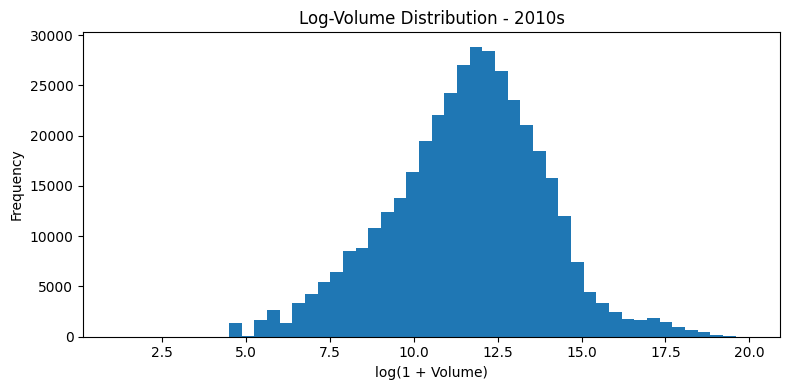

In [ ]:
for dec, df in decade_dfs.items():
    vol_log = np.log1p(df['volume'].dropna())  # log(1 + volume)
    plt.figure(figsize=(8, 4))
    plt.hist(vol_log, bins=50)
    plt.title(f'Log-Volume Distribution - {dec}s')
    plt.xlabel('log(1 + Volume)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

Volume shows a right-skewed distribution, so we also examined the log-transformed volume to better visualize the distribution and compare changes across decades

/tmp/ipython-input-3297195263.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(high_data, labels=[f'{dec}s' for dec in decades])


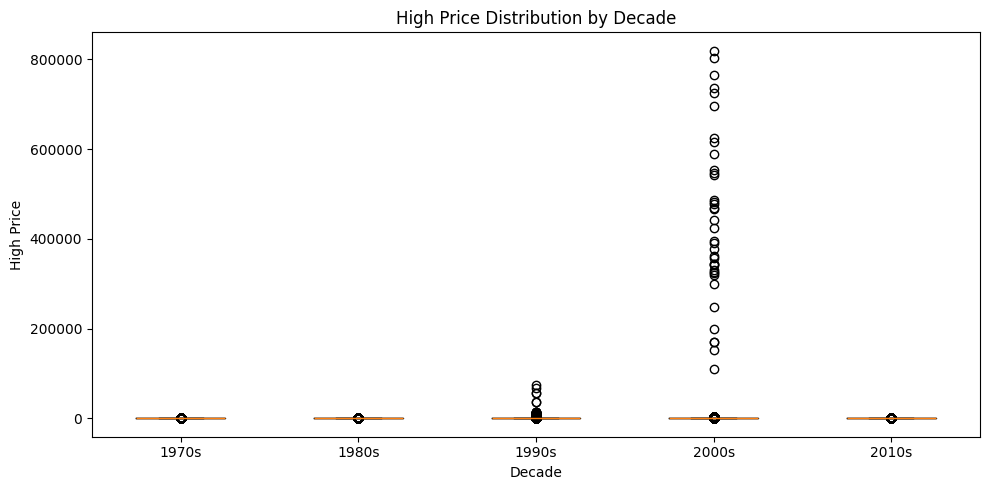

/tmp/ipython-input-3297195263.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(low_data, labels=[f'{dec}s' for dec in decades])


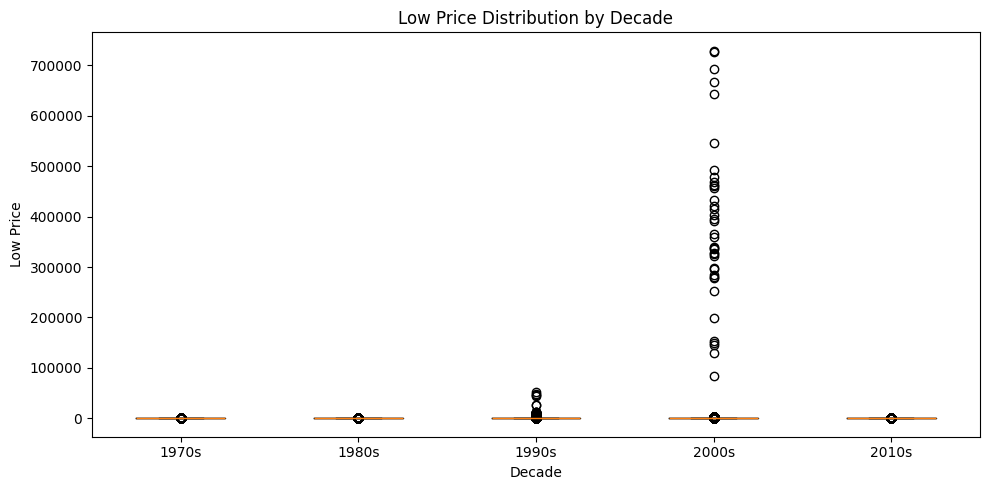

In [ ]:
# Box plots for High and Low prices by decade
decades = sorted(decade_dfs.keys())

# Prepare data for boxplot: one list per decade
high_data = [decade_dfs[dec]['high'].dropna() for dec in decades]
low_data  = [decade_dfs[dec]['low'].dropna() for dec in decades]

# Boxplot for High
plt.figure(figsize=(10, 5))
plt.boxplot(high_data, labels=[f'{dec}s' for dec in decades])
plt.title('High Price Distribution by Decade')
plt.xlabel('Decade')
plt.ylabel('High Price')
plt.tight_layout()
plt.show()

# Boxplot for Low
plt.figure(figsize=(10, 5))
plt.boxplot(low_data, labels=[f'{dec}s' for dec in decades])
plt.title('Low Price Distribution by Decade')
plt.xlabel('Decade')
plt.ylabel('Low Price')
plt.tight_layout()
plt.show()


We merged the daily price dataset with the stock metadata on the ticker key to enrich each record with sector information.
Using the datetime index, we created a decade column and computed summary statistics (mean, median, and standard deviation) for Open, High, Low, Close, and Volume by decade.
For exploratory analysis, we plotted the average monthly Close prices as time series for each decade, histograms of Volume to study distributional shifts, and box plots of High and Low prices to examine changes in price range and outliers over time.

# Task 5 Comparative Analysis: Stock Market Evolution Across Decades
1. Price Level Evolution
Key Observations:

1970s: Extremely low price levels (mean close: $0.64) with minimal volatility

1980s: Significant jump to mean close of $9.18, representing ~13x growth from 1970s

1990s: Another substantial increase to $34.75 mean close (~3.8x from 1980s)

2000s: Peak mean close at $100.56, but with extreme volatility (std: $5,467)

2010s: Correction to $31.24 mean close, suggesting market normalization

Notable Trend: The 2000s show anomalously high mean prices with massive standard deviation, indicating potential data issues or extreme outliers (possibly from stocks like BRK.A).

In [ ]:
# 2. Market Volatility Analysis
# Volatility comparison
print("Price Volatility by Decade:")
for decade in sorted(decade_dfs.keys()):
    volatility = decade_dfs[decade]['close'].std()
    print(f"{decade}s: ${volatility:,.2f}")

volatility_trend = {}
for decade, df in decade_dfs.items():
    volatility_trend[decade] = df['close'].std()

volatility_series = pd.Series(volatility_trend).sort_index()
print("\nPrice Volatility by Decade:")
print(volatility_series)

Price Volatility by Decade:
1970s: $0.29
1980s: $17.37
1990s: $381.71
2000s: $5,467.66
2010s: $47.10

Price Volatility by Decade:
1970       0.287178
1980      17.370954
1990     381.710526
2000    5467.656657
2010      47.100443
dtype: float64


Volatility Patterns:

1970s-1990s: Gradual, organic volatility increase from $0.29 to $382

2000s: Extreme volatility explosion to $5,468 - a 14x spike from the 1990s, representing the combined effects of:

Dot-com bubble (2000-2002)

Financial crisis (2008-2009

Structural market changes

2010s: Established a "new normal" at $47 - significantly lower than the crisis era, but permanently higher than the pre-2000 organic volatility regime, reflecting today's more complex, technology-driven markets.

3. Trading Volume Analysis
Volume Trends:

1970s: 1.38M mean volume - early market stage

1980s-1990s: Moderate growth to ~2M mean volume

2000s: Volume peak at 3.37M mean - electronic trading expansion

2010s: Volume decline to 1.50M mean, despite higher median (125,500 vs 116,600)

Interpretation: The 2010s show higher median but lower mean volume, indicating:

More consistent daily trading activity

Fewer extreme volume spikes compared to 2000s

Possible impact of algorithmic trading normalization

4. Box Plot Insights
From your High/Low box plots:

1970s-1980s: Tight ranges, few outliers - controlled markets

1990s: Range expansion begins, more outliers appear

2000s: Extreme outlier presence, massive range expansion

2010s: More normalized ranges, but maintained wider distribution than pre-2000s

In [ ]:
# 5. Market Structure Changes
# Trading Pattern Shifts:
# Calculate daily price ranges as percentage of price
for decade, df in decade_dfs.items():
    df['price_range_pct'] = (df['high'] - df['low']) / df['low'] * 100
    avg_range = df['price_range_pct'].mean()
    print(f"1970s-{decade}s: Average Daily Range = {avg_range:.2f}%")

1970s-1970s: Average Daily Range = 4.29%
1970s-1980s: Average Daily Range = 2.80%
1970s-1990s: Average Daily Range = 3.43%
1970s-2000s: Average Daily Range = 4.54%
1970s-2010s: Average Daily Range = 3.56%


The nature of market volatility has fundamentally transformed over 50 years.
1970s - "Low-Price Volatility": The high daily range (4.29%) was a mirage. It was caused by tiny price moves on extremely cheap stocks, reflecting a small, illiquid market.

2000s - "Crisis Volatility": The high daily range (4.54%) was real and dangerous. It occurred with high-priced stocks during major crises, representing massive wealth destruction.

2010s - "New Normal": The market settled into a structurally higher volatility (~3.5%) than the 1980s-90s, driven by algorithms and global capital, not just company fundamentals.

In short: The market evolved from a volatile pond (1970s), to a calm lake (80s/90s), through a hurricane (2000s), and is now a deeper, more complex ocean with constant swells (2010s-today).

6. Anomaly Detection
2000s Data Anomalies:

The massive standard deviation suggests potential data quality issues

Consider investigating:

Extreme outliers (possibly penny stocks or data errors)

Stock splits adjustment completeness

Inclusion of extremely high-priced stocks

7. Economic Context Correlation
Historical Events Reflected:

1970s: Stagflation, oil crisis → low, stable prices

1980s: Reaganomics, bull market begin → price growth

1990s: Tech boom, globalization → volatility increase

2000s: Dot-com bust, financial crisis → extreme volatility

2010s: Recovery, QE, tech dominance → normalization



Summary Conclusion
The data reveals three distinct market eras:

Pre-1990s: Traditional, low-volatility markets

1990s-2000s: Transition period with extreme volatility

2010s: Modern, technology-driven markets with higher baseline volatility but better risk management

Recommendation: For further analysis, consider:

Investigating the 2000s outliers

Analyzing sector-specific trends within each decade

Examining the impact of major economic events on decade-level statistics
